# Pytorch implementation of StyleGAN2 
#### from paper https://arxiv.org/pdf/1912.04958.pdf


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from modules import *
from loss import *
from misc import *

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

In [3]:
plt.rcParams['figure.figsize'] = (11,11)
plt.rcParams['image.cmap'] = 'gray'

### Generator architecture

In [4]:
class Generator(nn.Module):
    def __init__(self, min_res, max_res, min_fmaps, max_fmaps, act, 
                 k_size, blocks, img_channels, latent_size, n_layers, style_mixing_prob = 0.8,
                 dlatent_avg_beta = 0.995, weights_avg_beta=0.99, **kwargs):
        super().__init__()
        dres = min_res*2**blocks - max_res
        assert dres >= 0
        # building mapping net
        self.latent_size = latent_size
        self.mapping = Mapping(n_layers, latent_size, act)
        # learnable const
        self.const = nn.Parameter(torch.randn(max_fmaps, min_res, min_res))
        # building main layers
        fmaps = np.linspace(max_fmaps, min_fmaps, blocks+1).astype('int')
        self.layers = []
        for i in range(blocks):
            layer = G_Block(fmaps[i],fmaps[i+1], k_size, latent_size, act, img_channels=img_channels)
            self.add_module(str(i), layer)
            self.layers.append(layer)
        if dres > 0:
            self.crop = torch.nn.ZeroPad2d(-dres//2)
        # style mixing
        self.style_mixing_prob = style_mixing_prob 
        # running average of dlatents 
        self.dlatent_avg_beta = dlatent_avg_beta
        self.register_buffer('dlatent_avg', torch.zeros(latent_size))
        # running average of weights
        self.weights_avg_beta = weights_avg_beta
        self.Src_Net = deepcopy(self).apply(parameters_to_buffers)
        self.Src_Net.train(False)      
        
        
    # update running average of weights
    def update_avg_weights(self):
        params = dict(self.named_parameters())
        buffers = dict(self.named_buffers())
        for n,b in self.Src_Net.named_buffers():
            try:
                b.data.copy_(self.weights_avg_beta*b + (1-self.weights_avg_beta)*params[n])
            except:
                b.data.copy_(buffers[n])

            
    # sample dlatents
    def sample_dlatents(self, n):
        v = self._sample_dlatents(n)
        if self.training and self.style_mixing_prob > 0:
            l = len(self.layers)
            cut_off = torch.randint(l-1,())
            v2 = self._sample_dlatents(n)
            mask = torch.empty(n, dtype=torch.bool).bernoulli_(self.style_mixing_prob).view(-1, 1) \
                   * (torch.arange(l)>cut_off)
            v = torch.where(mask.unsqueeze(-1).to(device=v.device), v2, v)
        return v
    
    def _sample_dlatents(self, n):
        device = self.const.device
        z = torch.randn(n, self.latent_size).to(device)
        v = self.mapping(z)
        # update dlatent average
        if self.training:
            self.dlatent_avg = self.dlatent_avg_beta*self.dlatent_avg + (1-self.dlatent_avg_beta)*v.data.mean(0)
        # broadcast dlatents [N, dlatent_size] --> [N, num_layers, dlatent_size] 
        v = v.unsqueeze(1).expand(-1, len(self.layers), -1)
        return v
    
    
    # generate from dlatents and input noises (optionally)
    def generate(self, v, input_noises=None):
        x = self.const.expand(v.shape[0], *self.const.shape).contiguous()
        input_noises = input_noises if input_noises else [None]*len(self.layers)
        y = None
        for i,layer in enumerate(self.layers):
            x, y = layer(x,v[:,i],y, input_noises[i])  
        if hasattr(self, 'crop'):
            y = self.crop(y)
        return y
    
    
    # for training
    def sample(self, n):
        dlatents = self.sample_dlatents(n)
        x = self.generate(dlatents)
        return x
            
    
    # for evaluation
    def sample_images(self,n, truncation_psi=1):
        with torch.no_grad():
            v = self.Src_Net.sample_dlatents(n)
            # truncation trick
            if truncation_psi < 1:
                v = self.dlatent_avg + truncation_psi*(v-self.dlatent_avg)
            images = to_img(self.Src_Net.generate(v))
        return images

### Discriminator architecture

In [5]:
class Discriminator(nn.Module):
    def __init__(self, min_res, max_res, min_fmaps, max_fmaps, act, 
                 k_size, blocks, img_channels, dense_size=128, **kwargs):
        super().__init__()
        assert max_res <= min_res*2**blocks and max_res >= (min_res-1)*2**blocks
        # building layers
        fmaps = np.linspace(min_fmaps, max_fmaps, blocks+1).astype('int')
        self.from_channels = nn.Conv2d(img_channels, fmaps[0], 1)
        self.layers = []
        for i in range(blocks):
            layer = D_Block(fmaps[i],fmaps[i+1], k_size, act)
            self.add_module(str(i), layer)
            self.layers.append(layer)
        self.minibatch_sttdev = Minibatch_Stddev()
        self.conv = nn.Conv2d(fmaps[-1]+1,fmaps[-1], 3)
        self.dense = nn.Linear(fmaps[-1]*(min_res-2)**2, dense_size)
        self.output = nn.Linear(dense_size, 1)
        self.act = act
    
    
    def get_score(self, imgs):
        x = self.act(self.from_channels(imgs))
        for layer in self.layers:
            x = layer(x)
        x = self.minibatch_sttdev(x)
        x = self.act(self.conv(x))
        x = x.view(x.shape[0],-1)
        x = self.act(self.dense(x))
        x = self.output(x)
        return x

### Define training loop

In [6]:
def train(G, D, dataset, max_iter, batch_size, 
          G_opt_args, D_opt_args, mapping_opt_args,
          D_steps, pl_weight, r1_weight,
          r1_interval, pl_interval, val_interval, num_workers, pl_batch_part, checkpoint=None):
    
    pl_batch = int(pl_batch_part*batch_size)
    device = next(D.parameters()).device
    Path_length_reg = Path_length_loss()

    # create dataloader
    dataloader = NextDataLoader(dataset, batch_size, num_workers=num_workers)
    mean = dataset.transforms.transform.transforms[1].mean[0]
    std = dataset.transforms.transform.transforms[1].std[0]
    
    # load state
    if checkpoint:
        G.load_state_dict(checkpoint['G'])
        D.load_state_dict(checkpoint['D'])
        Path_length_reg.avg = checkpoint['pl_loss_avg']
    
    # create optimizer
    G_params = []
    for n,m in G.named_children():
        if n != 'mapping':
            G_params.extend(m.parameters())
    gen_optimizer = torch.optim.Adam([{'params': G_params},
                                  {'params': G.mapping.parameters(), **mapping_opt_args},
                                  {'params': G.const, **mapping_opt_args},
                                  ], **G_opt_args)
    disc_optimizer = torch.optim.Adam(D.parameters(), **D_opt_args)
    
    G.train()
    D.train()
    
    for i in tqdm(range(max_iter)):
        for j in range(D_steps):
            real_imgs = next(dataloader)[0].to(device)
            real_imgs.requires_grad = True
            fake_imgs = G.sample(real_imgs.shape[0])
            real_scores = D.get_score(real_imgs)
            fake_scores = D.get_score(fake_imgs)
            loss =  D_logistic(real_scores, fake_scores)
            if i % r1_interval == 0 and j == D_steps-1:
                loss += r1_weight*r1_interval*R1_reg(real_imgs, real_scores)
            real_imgs.requires_grad = False
            disc_optimizer.zero_grad()
            loss.backward()
            disc_optimizer.step()


        dlatent = G.sample_dlatents(batch_size)   
        if i % pl_interval == 0:
            # hack for computing path length loss from smaller minibatch
            dlatent_part1, dlatent_part_2 = dlatent[:pl_batch], dlatent[pl_batch:]
            fake_imgs = G.generate(torch.cat((dlatent_part1, dlatent_part_2), 0))
            fake_scores = D.get_score(fake_imgs)
            loss = G_logistic_ns(fake_scores) \
                   + pl_weight*pl_interval*Path_length_reg(dlatent_part1, fake_imgs[:pl_batch])
        else:
            fake_imgs = G.generate(dlatent)
            fake_scores = D.get_score(fake_imgs)
            loss = G_logistic_ns(fake_scores)  
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()
        G.update_avg_weights()

        
        if i % val_interval == 0:
            display.clear_output(wait=True)
            # print pictures
            gen = G.sample_images(32)*std+mean
            plt.imshow(grid(gen).squeeze())
            plt.show()
            # print prob distribution
            plt.figure(figsize=(5,5))
            plt.title('Generated vs real data')
            plt.hist(torch.sigmoid(real_scores.data).cpu().numpy(), label='D(x)', alpha=0.5,range=[0,1])
            plt.hist(torch.sigmoid(fake_scores.data).cpu().numpy(), label='D(G(z))',alpha=0.5,range=[0,1])
            plt.legend(loc='best')
            plt.show()


        if i % (20*val_interval) == 0:
            torch.save({
                        'G': G.state_dict(),
                        'D': D.state_dict(),
                        'pl_loss_avg': Path_length_reg.avg.item()
                        }, 'checkpoint.pt')

### Hyperparams

In [7]:
act = Scaled_Act(nn.LeakyReLU(0.2))
img_channels = 1
n_layers = 4
latent_size = 160
min_res = 4
max_res = 28
blocks = 3
k_size = 3
max_fmaps = 128
min_fmaps = 64
weights_avg_beta=0.995

device = 'cuda'

train_params = {'max_iter': 25000, 'batch_size' : 160, 
                'G_opt_args' : {'lr' : 0.001, 'betas' : (0.1, 0.99)}, 
                'D_opt_args' : {'lr' : 0.001, 'betas' : (0, 0.99), 'eps' : 1e-08}, 
                'mapping_opt_args' : {'lr' : 1e-5}, 
                'D_steps': 1, 'pl_weight': 2, 'r1_weight': 5, 'pl_batch_part': 0.25,
                'pl_interval': 4, 'r1_interval': 16, 'num_workers': 2, 'val_interval': 20}

### Training

In [8]:
G = Generator(min_res, max_res, min_fmaps, max_fmaps, act, 
              k_size, blocks, img_channels, latent_size, n_layers, weights_avg_beta=weights_avg_beta).to(device)

D = Discriminator(min_res, max_res, min_fmaps, max_fmaps, act, 
                   k_size, blocks, img_channels).to(device)

In [9]:
# Equalized learning rate
G = Equal_LR('weight')(G)
D = Equal_LR('weight')(D)

In [10]:
# Dataset
mean = 0.1307
std = 0.3081
dataset = MNIST('data', transform=T.Compose([T.ToTensor(), T.Normalize((mean,), (std,))]), download=True)

In [11]:
# Initialization
def init_weights(m):
    if hasattr(m, 'weight_orig'):
        torch.nn.init.normal_(m.weight_orig)
    if hasattr(m, 'bias'):
        torch.nn.init.zeros_(m.bias)
        
G.apply(init_weights)
D.apply(init_weights);

In [13]:
train(G, D, dataset, **train_params, checkpoint=torch.load('last_checkpoint.pt'))

### Evaluation

In [12]:
G.load_state_dict(checkpoint['G'])
D.load_state_dict(checkpoint['D'])

<All keys matched successfully>

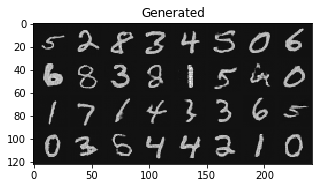

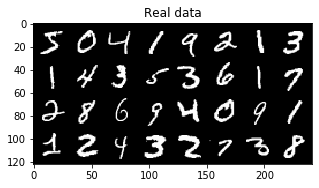

In [99]:
plt.title('Generated')
plt.imshow(grid(G.sample_images(32, 0.9)*std+mean).squeeze())
plt.show()

plt.title('Real data')
real_imgs = dataset.data[:32].unsqueeze(-1)
plt.imshow(grid(real_imgs).squeeze())
plt.show()

```







```
## Reverse mapping from images to latents

### Feedforward model

In [16]:
class E(nn.Module):
    def __init__(self, min_res, max_res, min_fmaps, max_fmaps, latent_size,
                 act, k_size, blocks, img_channels, dense_size=128, **kwargs):
        super().__init__()
        # building layers
        fmaps = np.linspace(min_fmaps, max_fmaps, blocks+1).astype('int')
        self.from_channels = nn.Conv2d(img_channels, fmaps[0], 1)
        self.layers = []
        self.noise_outs = []
        for i in range(blocks):
            layer = D_Block(fmaps[i],fmaps[i+1], k_size, act)
            self.add_module(str(i), layer)
            self.layers.append(layer)
            noise_out = nn.Conv2d(fmaps[i+1],2, 3, padding=1)
            self.add_module('noise'+str(i), noise_out)
            self.noise_outs.append(noise_out)
            
        self.conv = nn.Conv2d(fmaps[-1]+1,fmaps[-1], 3)
        self.dense = nn.Linear(fmaps[-1]*(min_res-2)**2, dense_size)
        self.output = nn.Linear(dense_size, latent_size)
        self.act = act
    
    def get_latents(self, imgs):
        noises = []
        x = self.from_channels(imgs)
        for i,layer in enumerate(self.layers):
            x = layer(x)
            noises.append(self.noise_outs[i](x))
        x = self.minibatch_sttdev(x)
        x = self.act(self.conv(x))
        x = x.view(x.shape[0],-1)
        x = self.act(self.dense(x))
        dlatents = self.output(x)
        return dlatents, noises
        

In [17]:
def train_E(G, E, max_iter, batch_size, E_opt_args, mapping_opt_args,
            pl_weight, r1_weight,
          r1_interval, pl_interval, val_interval, num_workers):
    # create dataloader
    dataloader = NextDataLoader(dataset, batch_size, num_workers=num_workers)
    # create optimizer
    optimizer = torch.optim.Adam(D.parameters(), **D_opt_args)
    Path_length_reg = Path_length_loss()
    for i in tqdm(range(max_iter)):
        for j in range(D_steps):
            real_imgs = next(dataloader)[0].cuda()
            real_imgs.requires_grad = True
            dlatent = G.sample_dlatents(real_imgs.shape[0])
            fake_imgs = G.generate(dlatent)
            real_scores = D.get_score(real_imgs)
            fake_scores = D.get_score(fake_imgs)
            loss =  D_logistic(real_scores, fake_scores)
            if i % r1_interval == 0 and j == D_steps-1:
                loss += r1_weight*r1_interval*R1_reg(real_imgs, real_scores)
            real_imgs.requires_grad = False
            disc_optimizer.zero_grad()
            loss.backward()
            disc_optimizer.step()
            disc_scheduler.step()

        dlatent = G.sample_dlatents(batch_size)
        fake_imgs = G.generate(dlatent)
        fake_scores = D.get_score(fake_imgs)    
        loss = G_logistic_ns(fake_scores)    
        if i % pl_interval == 0:
            loss += pl_weight*pl_interval*Path_length_reg(dlatent, fake_imgs)   
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()
        gen_scheduler.step()
        G.update_avg_weights()

        
        if i % val_interval == 0:
            display.clear_output(wait=True)
            # print pictures, Generator performance
            # real = real_imgs[:32].permute(0,2,3,1).cpu().numpy()
            # plt.imshow(grid(real).squeeze())
            # plt.show()
            gen = fake_imgs[:32].detach().permute(0,2,3,1).cpu().numpy()
            plt.imshow(grid(gen).squeeze())
            plt.show()
            # print prob distribution, Discriminator performance
            plt.figure(figsize=(5,5))
            plt.title('Generated vs real data')
            plt.hist(torch.sigmoid(real_scores.data).cpu().numpy(), label='D(x)', alpha=0.5,range=[0,1])
            plt.hist(torch.sigmoid(fake_scores.data).cpu().numpy(), label='D(G(z))',alpha=0.5,range=[0,1])
            plt.legend(loc='best')
            plt.show()


        if i % 500 == 0:
            torch.save(G.state_dict(), '/content/drive/My Drive/Checkpoints/'+'G.pt')
            torch.save(D.state_dict(), '/content/drive/My Drive/Checkpoints/'+'D.pt')

```


```
### Optimization

#### Projection method described in StyleGAN2 paper

In [22]:
plt.rcParams['figure.figsize'] = (5,5)

In [101]:
class Projector():
    def __init__(self,
                 G, # generator
                 image_loss, # loss for comparing generated and target images
                 noise_reg_weight= 1e5, # weight for noise regularization,  None -> regularization disabled
                 dlatent_avg_samples = 10000,  # number of samples for computing avg and std
                 max_lr = 0.1, lr_rampdown_length = 0.25, lr_rampup_length = 0.05, # lr params
                 noise_factor = 0.05, noise_ramp_length  = 0.75 # dlatents noise params
                ):
        for n, v in locals().items():
            if n != 'self':
                setattr(self, n, v)
        self.G.eval()


    def compute_init_approx(self):
        dlatents = self.G.sample_dlatents(self.dlatent_avg_samples).detach()
        self.dlatents_avg = torch.mean(dlatents, dim = 0, keepdim=True)
        self.dlatents_std = (torch.sum((dlatents - self.dlatents_avg) ** 2)/self.dlatent_avg_samples) ** 0.5
        min_res = self.G.const.shape[-1]
        self.noise_maps_shapes = [(1, 2 , 1, min_res*2**i, min_res*2**i) for i in range(1,len(self.G.layers)+1)]


    def lr_schedule(self, step):
        t = step/self.num_steps
        x = min(1, t/self.lr_rampup_length)
        if t > (1-self.lr_rampdown_length):
            x = np.sin(0.5*np.pi*(1-t)/self.lr_rampdown_length)
        return(x)


    @staticmethod
    def show(image):
        plt.imshow(to_img(image).squeeze())
        plt.show()


    def run(self, target_image, num_steps=1000):
        self.num_steps = num_steps
        if not hasattr(self, 'dlatents_avg'):
            self.compute_init_approx()
        # initialize optimizable variables
        dlatents = self.dlatents_avg.clone().requires_grad_(True)
        noise_maps = [torch.randn(s, device=dlatents.device).requires_grad_(True) for s in self.noise_maps_shapes]
        # create opt and lr scheduler
        optimizer = torch.optim.Adam([dlatents, *noise_maps], lr=self.max_lr)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, self.lr_schedule)
        # iterations
        for step in tqdm(range(self.num_steps)):
            # generate noise for dlatents
            noise_strength = self.dlatents_std*self.noise_factor*max(1-(step/self.num_steps)/self.noise_ramp_length, 0)
            dlatents_noise = torch.randn_like(dlatents)*noise_strength
            # generate image
            image = self.G.generate(dlatents + dlatents_noise, noise_maps)
            # compute loss
            loss = self.image_loss(image, target_image)
            if not self.noise_reg_weight is None:
                loss += self.noise_reg_weight * Noise_reg(noise_maps)
            # backward pass, opt and scheduler steps
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            # show result
            display.clear_output(wait=True)
            Projector.show(image)
        return dlatents.data, [nmap.data for nmap in noise_maps]

#### The image quality term is the LPIPS distance. But in this simple case, $L_2$ works just as well.

In [105]:
import sys
sys.path.append("../PerceptualSimilarity/")
from models import PerceptualLoss

In [110]:
image_loss = PerceptualLoss(model='net-lin', net='squeeze', use_gpu=False)
# for some reason, a cuDNN error occurs when using GPU
G.cpu();

Setting up Perceptual loss...
Loading model from: /home/o2chan/PerceptualSimilarity/models/weights/v0.1/squeeze.pth
...[net-lin [squeeze]] initialized
...Done


In [111]:
proj = Projector(G, image_loss)

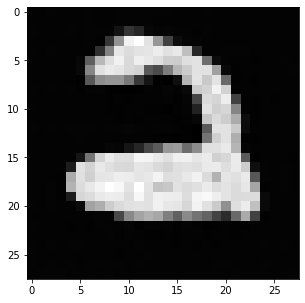

In [112]:
target_image = G.sample(1)
plt.imshow(to_img(target_image).squeeze())
plt.show()

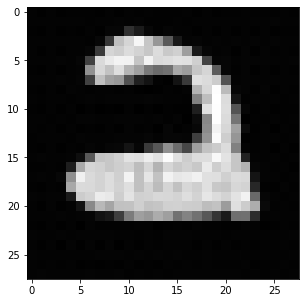

100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


In [113]:
dlatents, noise_maps = proj.run(target_image.data, num_steps=1000)

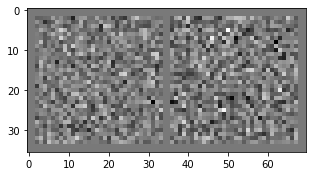

In [96]:
plt.imshow(grid(to_img(noise_maps[-1][0])).squeeze())
plt.show()

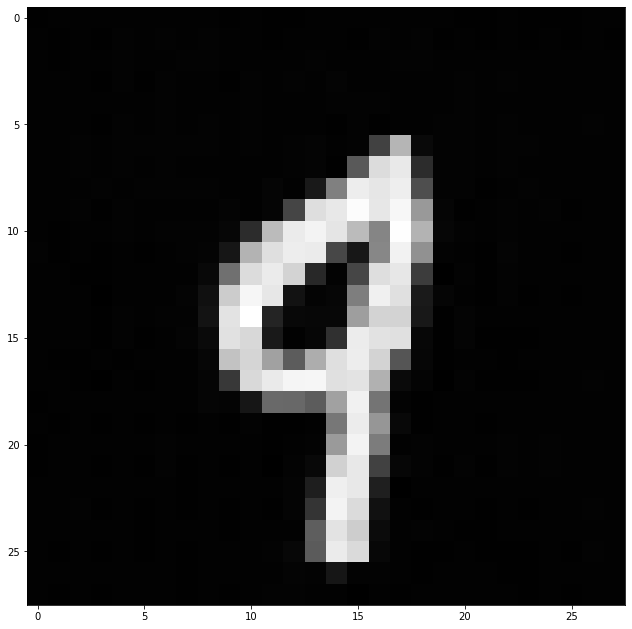

100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


(tensor([[[ 9.3514e-01,  1.8595e+00,  6.9791e-01,  2.5512e+00, -1.1447e+00,
            1.1047e+00,  1.7180e+00,  6.1052e-01,  1.1243e+00,  2.5761e+00,
           -5.3197e-01,  2.6944e+00,  6.5478e-01,  2.1000e+00,  1.3951e+00,
            7.5645e-01,  1.2145e+00, -5.3316e-01,  1.4161e+00,  1.4594e+00,
            7.6951e-01, -4.9682e-01, -1.8269e+00,  5.2746e-01,  1.4510e+00,
            1.3055e+00, -8.9283e-01,  1.6473e+00, -7.4953e-01,  7.2668e-01,
            9.2205e-01,  7.8513e-01, -5.7380e-02,  9.5379e-01, -3.1963e-01,
            7.1887e-01, -1.2994e+00,  1.6434e+00,  5.0648e-01,  1.6169e+00,
            6.7164e-01,  1.6313e+00,  1.1981e+00,  2.2010e-01,  2.2499e-01,
           -2.4692e+00, -1.8606e-02,  2.2367e+00,  7.4219e-01,  6.4794e-01,
           -6.0846e-01,  2.8436e-01, -1.9277e-02,  5.4923e-01,  8.9590e-01,
           -3.4063e-01,  1.0916e-01,  8.1984e-01,  1.9476e+00,  1.7713e+00,
            9.5836e-01, -7.7190e-01, -1.0002e-01, -2.9172e-01,  2.6753e-02,
            

In [52]:
loss = torch.mean((image-target_image)**2)